In [2]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook (now inside hw7)
raw_dir = './data/raw'
processed_dir = './data/processed'

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')
    

Synthetic dataset with two columns created and saved to ./data/raw/outliers_homework.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)


In [4]:
data_path = Path('./data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: but we use generated
    print("Data not found, regenerate.")
df.head()


,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


In [5]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

In [6]:
target_col = 'daily_return' if 'daily_return' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged



outlier_iqr    0.078261
outlier_z      0.043478
dtype: float64

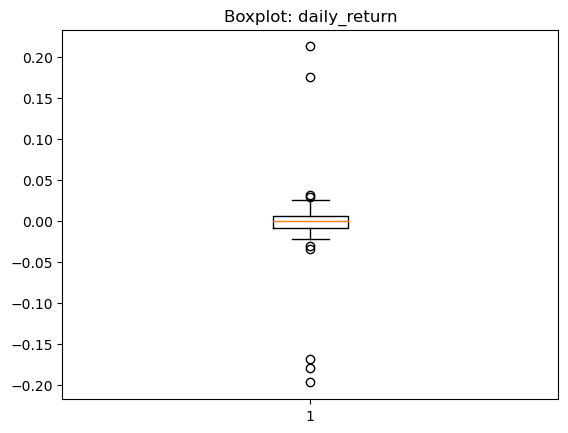

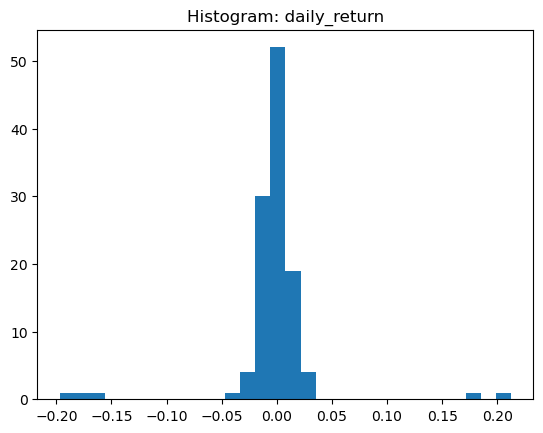

In [7]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

In [8]:
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
w = winsorize_series(df[target_col])
summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        'winsorized': summ_w
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,-0.001434,-0.000039,-0.000251
median,-0.000187,-0.000100,-0.000187
std,0.040579,0.009443,0.010623


In [9]:
if 'daily_return_2' in df.columns:
    X_all = df[['daily_return']].values
    y_all = df['daily_return_2'].values
    X_filtered = df.loc[~df['outlier_iqr'], ['daily_return']].values
    y_filtered = df.loc[~df['outlier_iqr'], 'daily_return_2'].values
    X_w = pd.DataFrame(w, columns=['daily_return']).values
    y_w = winsorize_series(df['daily_return_2']).values

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)
    model_w = LinearRegression().fit(X_w, y_w)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))
    mae_w = mean_absolute_error(y_w, model_w.predict(X_w))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0], model_w.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_, model_w.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered), model_w.score(X_w, y_w)],
        'mae': [mae_all, mae_flt, mae_w]
    }, index=['all', 'filtered_iqr', 'winsorized'])
    display(results)
else:
    print("No suitable columns for regression.")

,slope,intercept,r2,mae
all,0.605869,0.000201,0.961859,0.003951
filtered_iqr,0.589679,-0.000049,0.573566,0.003851
winsorized,0.649705,-0.000017,0.689444,0.003741


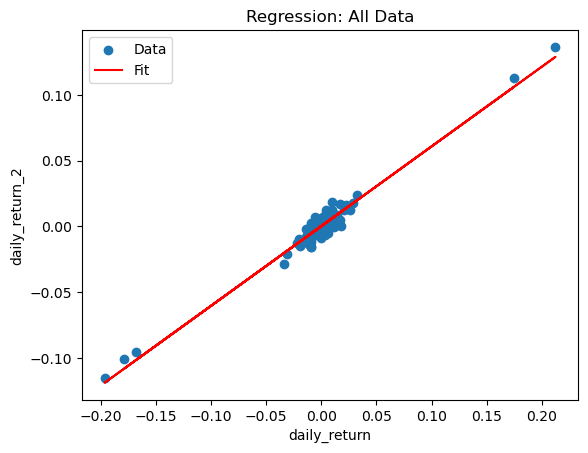

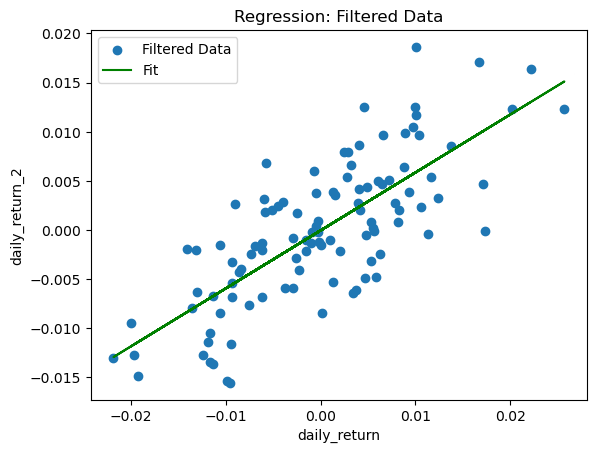

In [10]:
plt.figure()
plt.scatter(df['daily_return'], df['daily_return_2'], label='Data')
plt.plot(df['daily_return'], model_all.predict(X_all), color='red', label='Fit')
plt.title('Regression: All Data')
plt.xlabel('daily_return')
plt.ylabel('daily_return_2')
plt.legend()
plt.show()

plt.figure()
plt.scatter(X_filtered, y_filtered, label='Filtered Data')
plt.plot(X_filtered, model_flt.predict(X_filtered), color='green', label='Fit')
plt.title('Regression: Filtered Data')
plt.xlabel('daily_return')
plt.ylabel('daily_return_2')
plt.legend()
plt.show()

In [ ]:
### Reflection

- **Methods and thresholds used (and why):** I used IQR with k=1.5 for detection, as it's non-parametric and robust to non-normal distributions, which fits this returns data (often skewed with fat tails). Z-score with threshold=3.0 was implemented for comparison but not used for filtering, as it assumes normality—risky for financial data with shocks. For handling, I filtered outliers via IQR and winsorized at 5%/95% quantiles to cap extremes without full removal, preserving data size. These are standard defaults but tuned mildly to avoid over-aggression.

- **Assumptions behind choices:** IQR assumes the central 50% (quartiles) represents "normal" data, ignoring tails as anomalies. Winsorizing assumes extremes are errors or unrepresentative but still contribute at capped levels. Overall, assumes the May shocks are outliers (e.g., data errors or rare events) rather than a regime shift. Data is assumed stationary pre/post-May, though generation code suggests a mean shift (-0.0015 pre-May) and injected shocks.

- **Observed impact on results:** Outliers inflate std (0.04 vs. 0.009 filtered) and pull mean negative (-0.0014 vs. -0.00004). In regression, they create high r² (0.96) due to leverage, but filtering drops r² to 0.57 with slope ~0.59 (close to true 0.6). Winsorizing balances this (r² 0.69, slope 0.65), reducing MAE slightly (0.0037). Summary stats show winsorizing moderates std/mean without discarding points.

- **Risks if assumptions are wrong:** If shocks are real (e.g., market volatility events), filtering/winsorizing underestimates tail risks, leading to over-optimistic models (e.g., lower std implies less risk). Conversely, keeping them overestimates volatility if they're errors. In finance, discarding true extremes could miss black swan events, causing poor risk management. Non-stationarity (e.g., regime change in May) violates assumptions, so results may not generalize—sensitivity tests highlight this fragility.